# Import Library


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.style.use('ggplot')

import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!wget -q http://www.arts.chula.ac.th/ling/wp-content/uploads/TH-Sarabun_Chula1.1.zip -O font.zip
!unzip -qj font.zip TH-Sarabun_Chula1.1/THSarabunChula-Regular.ttf

import matplotlib as mpl
mpl.font_manager.fontManager.addfont('THSarabunChula-Regular.ttf')
mpl.rc('font', family='TH Sarabun Chula')

# Read Data

In [3]:
# Load the Excel file into a Pandas dataframe
df = pd.read_csv('teamchadchart.csv')

# Drop some columns
drop_col = [
    'ticket_id', 'address', 'comment', 'photo', 'photo_after', 
    'star', 'count_reopen', 'last_activity', 'organization'
]
df.drop(drop_col, axis=1, inplace=True)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.date())

# split coordinate column into separate latitude and longitude columns
df[['latitude', 'longitude']] = df['coords'].str.split(',', expand=True)

# drop the original coordinate column
df.drop(['coords'], axis=1, inplace=True)
df.head()

,type,subdistrict,district,province,timestamp,state,latitude,longitude
0,{ร้องเรียน},กระทุ่มราย,หนองจอก,กรุงเทพมหานคร,2023-05-12,รอรับเรื่อง,100.87281,13.81565
1,{สายไฟ},บางบอนใต้,บางบอน,กรุงเทพมหานคร,2023-05-12,รอรับเรื่อง,100.39037,13.64517
2,"{กีดขวาง,ถนน}",บางยี่เรือ,ธนบุรี,กรุงเทพมหานคร,2023-05-12,รอรับเรื่อง,100.48866,13.72368
3,{ทางเท้า},บางหว้า,ภาษีเจริญ,กรุงเทพมหานคร,2023-05-12,รอรับเรื่อง,100.43366,13.71289
4,{ท่อระบายน้ำ},สะพานสูง,สะพานสูง,กรุงเทพมหานคร,2023-05-12,รอรับเรื่อง,100.66626,13.77315


In [4]:
# rename province in Bangkok
df['province'] = df['province'].apply(lambda x: "กรุงเทพมหานคร" if x == "จังหวัดกรุงเทพมหานคร" else x)

# split 'type' in each row to list datatype
df['type'] = df['type'].apply(lambda x: x.strip('{}').split(','))

# add new column to count 'type' length
df['type_count'] = df['type'].apply(lambda x: len(x))
df.head()

,type,subdistrict,district,province,timestamp,state,latitude,longitude,type_count
0,[ร้องเรียน],กระทุ่มราย,หนองจอก,กรุงเทพมหานคร,2023-05-12,รอรับเรื่อง,100.87281,13.81565,1
1,[สายไฟ],บางบอนใต้,บางบอน,กรุงเทพมหานคร,2023-05-12,รอรับเรื่อง,100.39037,13.64517,1
2,"[กีดขวาง, ถนน]",บางยี่เรือ,ธนบุรี,กรุงเทพมหานคร,2023-05-12,รอรับเรื่อง,100.48866,13.72368,2
3,[ทางเท้า],บางหว้า,ภาษีเจริญ,กรุงเทพมหานคร,2023-05-12,รอรับเรื่อง,100.43366,13.71289,1
4,[ท่อระบายน้ำ],สะพานสูง,สะพานสูง,กรุงเทพมหานคร,2023-05-12,รอรับเรื่อง,100.66626,13.77315,1


# Remove Outliers

In [5]:
from scipy import stats

# convert coord column to float
df = df.astype({"latitude": float, "longitude": float})

# Calculate z-scores for latitude and longitude columns
z_lat  = np.abs(stats.zscore(df['latitude']))
z_long = np.abs(stats.zscore(df['longitude']))

# Define threshold value
threshold = 3

# Remove outliers from the dataframe
df = df[(z_lat < threshold) & (z_long < threshold)]
print(f"There are {df.shape[0]} rows after removing outliners.")

There are 997 rows after removing outliners.


In [6]:
# explode list of type to multiple rows
df_exploded = df.explode('type')
df_exploded.drop('type_count', axis=1, inplace=True)
df_exploded.head()

,type,subdistrict,district,province,timestamp,state,latitude,longitude
0,ร้องเรียน,กระทุ่มราย,หนองจอก,กรุงเทพมหานคร,2023-05-12,รอรับเรื่อง,100.87281,13.81565
1,สายไฟ,บางบอนใต้,บางบอน,กรุงเทพมหานคร,2023-05-12,รอรับเรื่อง,100.39037,13.64517
2,กีดขวาง,บางยี่เรือ,ธนบุรี,กรุงเทพมหานคร,2023-05-12,รอรับเรื่อง,100.48866,13.72368
2,ถนน,บางยี่เรือ,ธนบุรี,กรุงเทพมหานคร,2023-05-12,รอรับเรื่อง,100.48866,13.72368
3,ทางเท้า,บางหว้า,ภาษีเจริญ,กรุงเทพมหานคร,2023-05-12,รอรับเรื่อง,100.43366,13.71289


In [7]:
print(f"There are {df.shape[0]} rows in df dataframe.")
print(f"There are {df_exploded.shape[0]} rows in df_exploded dataframe.")

There are 997 rows in df dataframe.
There are 1630 rows in df_exploded dataframe.


# Clean Data

In [8]:
df_exploded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1630 entries, 0 to 999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   type         1630 non-null   object 
 1   subdistrict  1630 non-null   object 
 2   district     1630 non-null   object 
 3   province     1630 non-null   object 
 4   timestamp    1630 non-null   object 
 5   state        1630 non-null   object 
 6   latitude     1630 non-null   float64
 7   longitude    1630 non-null   float64
dtypes: float64(2), object(6)
memory usage: 114.6+ KB


In [9]:
# number of missing values
null_counts = df_exploded.isnull().sum()
print(f"\nNumber of null values in each column after imputing:\n{null_counts}")


Number of null values in each column after imputing:
type           0
subdistrict    0
district       0
province       0
timestamp      0
state          0
latitude       0
longitude      0
dtype: int64


In [10]:
# before cleaning empty string
print(f"There are {df_exploded.shape[0]} rows before cleaning.")

# after cleaning empty string
df_exploded['type'] = df_exploded['type'].str.strip()
df_exploded.drop(df_exploded[df_exploded['type'] == ''].index, inplace=True)
print(f"There are {df_exploded.shape[0]} rows after cleaning.")

There are 1630 rows before cleaning.
There are 1534 rows after cleaning.


# Visualize Data

In [11]:
def compare_count_plot(data, column, title):
    # create a new font with Thai support
    font_path = 'THSarabunChula-Regular.ttf'

    # df_exploded[column].value_counts()
    type_list = df_exploded[column].value_counts().index

    # set font
    sns.set(font_scale=2)
    sns.set(rc={'figure.figsize': (12, 8)})
    sns.set(font=fm.FontProperties(fname=font_path).get_name())

    # plot bar graph
    sns.countplot(y=column, data=data, order=type_list)
    plt.title(title)
    plt.show()

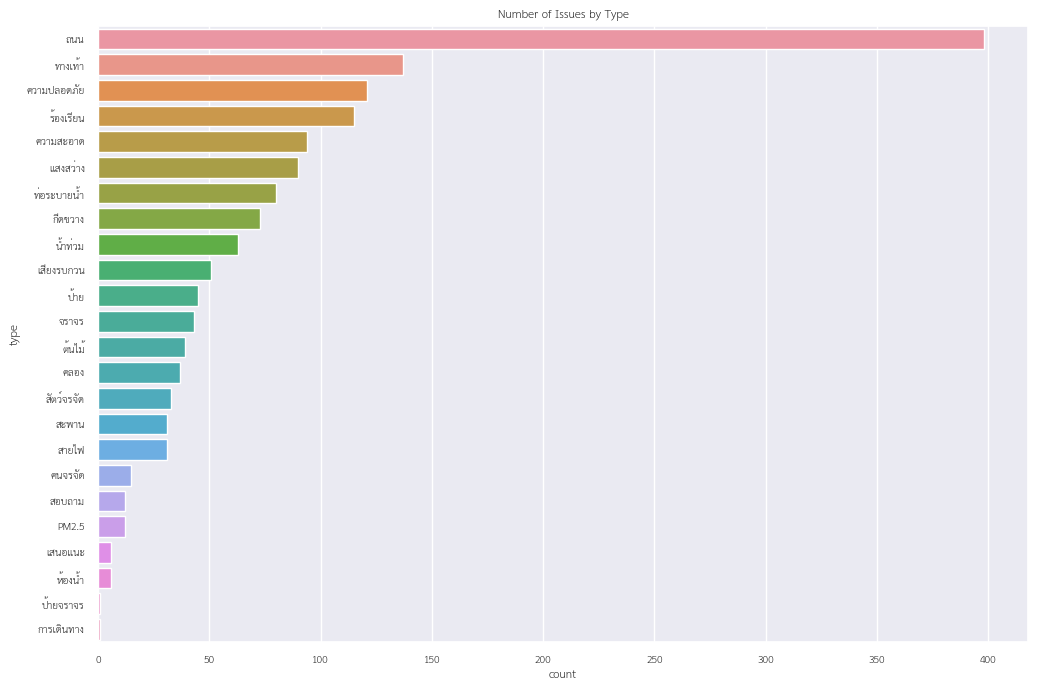

In [12]:
compare_count_plot(df_exploded, 'type', 'Number of Issues by Type')

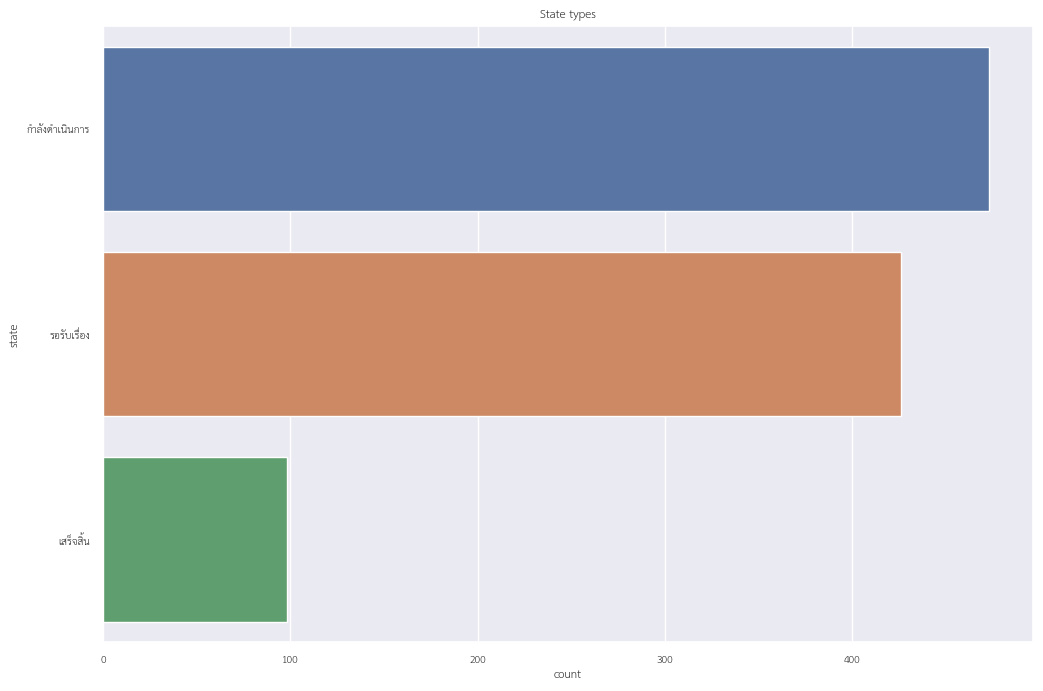

In [13]:
compare_count_plot(df, 'state', 'State types')

In [14]:
df['province'].value_counts()

กรุงเทพมหานคร    996
สมุทรปราการ        1
Name: province, dtype: int64

In [15]:
df['type_count'].value_counts()

1    571
2    267
3    121
4     28
5     10
Name: type_count, dtype: int64

# Geospatial Visualize

In [38]:
import folium

# size factor
factor = 3

# color procedure
def color_producer(count):
    if count == 1:
        return 'green'
    elif count == 2:
        return 'blue'
    elif count == 3:
        return 'orange'
    else:
        return 'red'

# Create a map centered on a specific location
traffy_map = folium.Map(location=[13.7563, 100.5018], zoom_start=11)
folium.TileLayer('stamenterrain').add_to(traffy_map)

# Loop through the rows of the dataframe and add a marker for each location
for index, row in df.iterrows():
    lat = float(row['latitude'])
    lon = float(row['longitude'])
    count = int(row['type_count'])

    # Pop up information
    information = f"<b>Problem Count: {count}</b> <br><br> Province: {row['province']} <br> District: {row['district']}"
    information += f" <br> State: {row['state']} <br> Problem: {row['type']} <br> Timestamp: {row['timestamp']}"

    iframe = folium.IFrame(information)
    popup = folium.Popup(iframe, min_width=300, max_width=300, min_height=150, max_height=180)

    # Add marker by size to the map
    folium.CircleMarker(
        location=[lon, lat],
        radius=count * factor,
        popup=popup,
        fill=True,
        fill_color=color_producer(count),
        color = 'black',
        fill_opacity=0.7
    ).add_to(traffy_map)

# Save traffy_map to html file
traffy_map.save("TraffyMap.html")
traffy_map

# K-Mean Clustering Model

In [17]:
from sklearn.preprocessing import StandardScaler

selected = ['latitude', 'longitude']
df_describe = df[selected]

x = df_describe.values

# Standardize variables with Standard Scaler
scaler = StandardScaler()
scaler.fit(x)

cluster_data = scaler.fit_transform(x)
cluster_data

array([[ 3.16199137,  0.87536835],
       [-1.7462205 , -1.98004367],
       [-0.74624507, -0.66506011],
       ...,
       [-1.13437268, -2.29124472],
       [ 0.46686989,  0.55880754],
       [ 0.36787955, -0.96704907]])

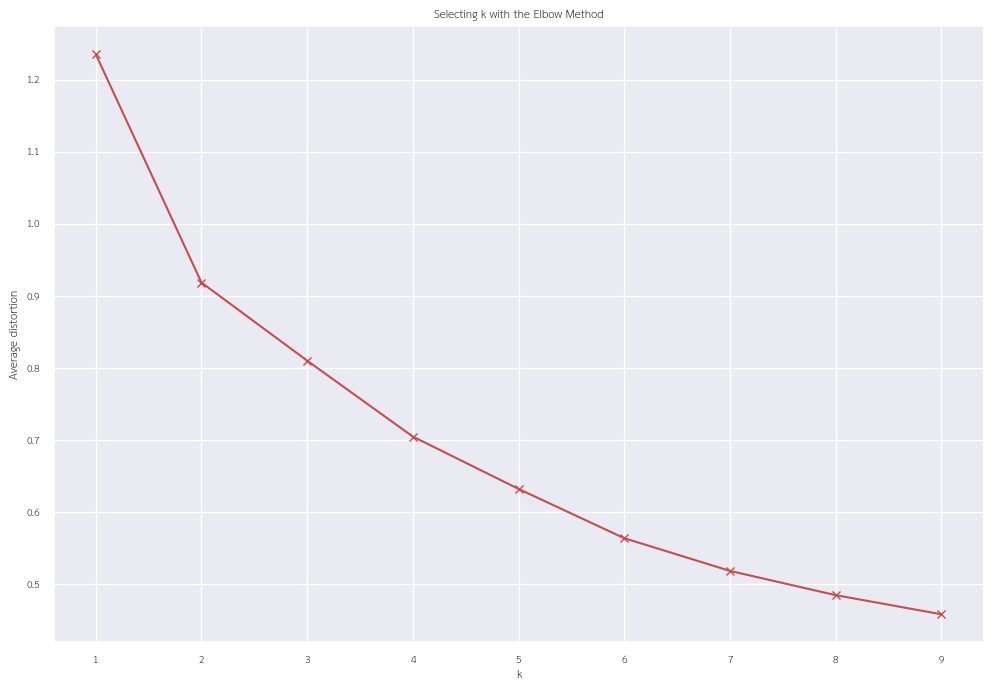

In [18]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

# Initialize the plot with the specified dimensions
fig = plt.figure(figsize=(12, 8))

# elbow method, to determine the optimal number of clusters
meandistortions = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=2020)
    kmeans.fit(cluster_data)
    summation = sum(np.min(cdist(cluster_data, kmeans.cluster_centers_, 'euclidean'), axis=1))
    meandistortions.append(summation / cluster_data.shape[0])

plt.plot(range(1, 10), meandistortions, 'rx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')
plt.show()

In [19]:
kmeans = KMeans(n_clusters=2, random_state=2020)
kmeans.fit(cluster_data)

KMeans(n_clusters=2, random_state=2020)

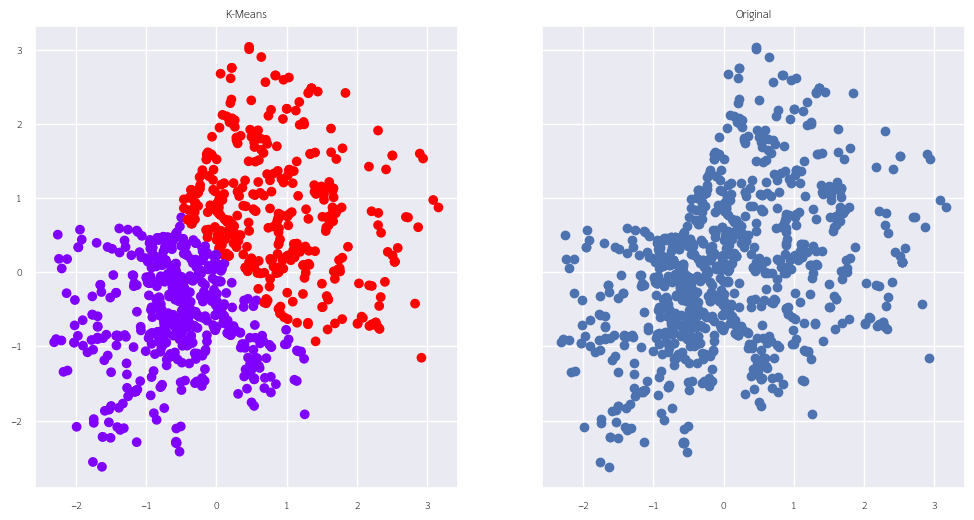

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

ax1.set_title('K-Means')
ax1.scatter(cluster_data[:, 0], cluster_data[:, 1], c=kmeans.labels_, cmap='rainbow')

ax2.set_title("Original")
ax2.scatter(cluster_data[:, 0], cluster_data[:, 1], cmap='rainbow')
plt.show()

## Show the centroid of each cluster

In [21]:
# inverse transform to get original centroids back
original_data = scaler.inverse_transform(kmeans.cluster_centers_)

# get unique size for each clusters
(unique, counts) = np.unique(kmeans.labels_, return_counts=True)

print(f"Normalize data:\n{'-' * 30}")
for idx, (x, y) in enumerate(kmeans.cluster_centers_):
    print(f"centroid {idx + 1} = ({x:5.2f}, {y:5.2f}), size = {counts[idx]}")

print(f"\nOriginal data:\n{'-' * 30}")
for idx, (x, y) in enumerate(original_data):
    print(f"centroid {idx + 1} = ({x:.2f}, {y:.2f})")

Normalize data:
------------------------------
centroid 1 = (-0.57, -0.55), size = 594
centroid 2 = ( 0.84,  0.81), size = 403

Original data:
------------------------------
centroid 1 = (100.51, 13.73)
centroid 2 = (100.64, 13.81)


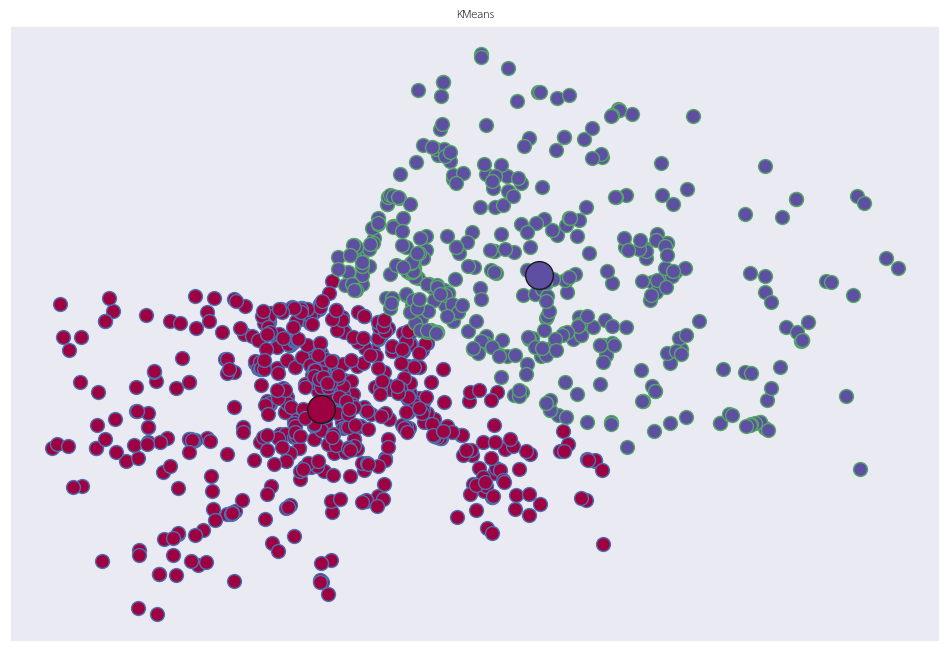

In [22]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(12, 8))

# Colors uses a color map, which will produce an array of colors based on the
# number of labels there are. We use set(kmeans_labels) to get the unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(kmeans.labels_))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# For loop that plots the data points and centroids.
for k, col in zip(range(len(kmeans.cluster_centers_)), colors):

    # Create a list of all data points, where the data points that are in the cluster 
    # (ex. cluster 0) are labeled as true, else they are labeled as false.
    my_members = (kmeans.labels_ == k)
    
    # Define the centroid, or cluster center.
    cluster_center = kmeans.cluster_centers_[k]
    
    # Plots the datapoints with color col.
    ax.plot(cluster_data[my_members, 0], cluster_data[my_members, 1], 'o', markerfacecolor=col, markersize=10)
    
    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=20)

# Title of the plot
ax.set_title('KMeans')

# Remove x-axis ticks
ax.set_xticks(())

# Remove y-axis ticks
ax.set_yticks(())

# Show the plot
plt.show()

# DBSCAN

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [23]:
from sklearn.metrics.pairwise import haversine_distances

# Handling Location
points_in_radians = df[['latitude', 'longitude']].apply(np.radians).values
distances_in_km = haversine_distances(points_in_radians) * 6371

In [24]:
from sklearn.cluster import DBSCAN

# distance_matrix = rating_distances + distances_in_km
distance_matrix = distances_in_km

clustering = DBSCAN(metric='precomputed', eps=1, min_samples=3)
clustering.fit(distance_matrix)

DBSCAN(eps=1, metric='precomputed', min_samples=3)

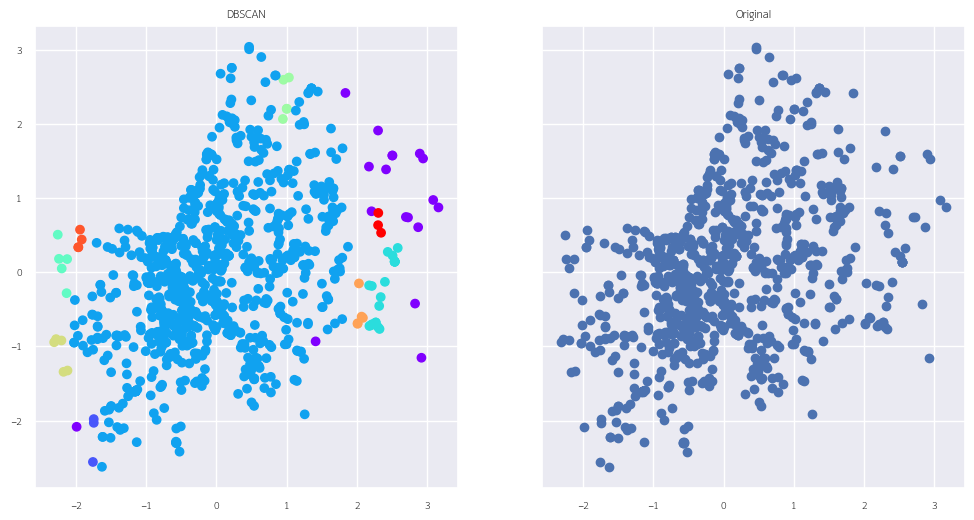

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

ax1.set_title('DBSCAN')
ax1.scatter(cluster_data[:, 0], cluster_data[:, 1], c=clustering.labels_, cmap='rainbow')

ax2.set_title("Original")
ax2.scatter(cluster_data[:, 0], cluster_data[:, 1], cmap='rainbow')
plt.show()

# Broke Heatmap

In [26]:
from folium import plugins
from folium.plugins import HeatMap